In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
from ames_preprocessing import col_splits

# Import & clean

In [2]:
#Import dataset
data = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col = 0)

In [238]:
#Create the clean dataframe
housing = data.copy().drop_duplicates().reset_index(drop=True)

#Separate columns for preprocessing
col_groups = col_splits(housing)
areas = col_groups['areas']
frontage = col_groups['frontage']
miscval = col_groups['miscval']
conditions = col_groups['conditions']
inspect10pt = col_groups['inspect10pt']
inspect5pt = col_groups['inspect5pt']
inspections = col_groups['inspections']
dates = col_groups['dates']
counts = col_groups['counts']
categoricals = col_groups['categoricals']

#Prep & check NaNs
#Assume NaN in area/length column implies doesn't have this feature, hence would be 0 sqft of that feature
housing[areas] = housing[areas].fillna(0.)
housing[frontage] = housing[frontage].fillna(0.)

#Convert rating Poor = 0, Fair = 1, Average = 2, Good = 3, Excellent = 4, keeping NaNs
housing[inspect5pt] = housing[inspect5pt].applymap(lambda x: 
                                                   {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4, np.nan:np.nan}[x])

## NaNs

### Manual data removal/imputation

In [4]:
#A bunch of info is missing from one entry about garages. Remove garage info, as seems like "unofficial" garage.
housing[housing['GarageCond'].isna() & (housing['GarageArea'] != 0)].filter(regex = 'Garage')

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
531,Detchd,NaN,NaN,1.0,360.0,NaN,NaN


In [5]:
#Similarly, there is one house which is indicated as having a detached garage, but no other info. Remove the garage info.
housing[housing.GarageType.notnull() & (housing.GarageArea == 0)].filter(regex = 'Garage')

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
433,Detchd,NaN,NaN,NaN,0.0,NaN,NaN


Basement finish type is missing for one entry with a basement. Impute the same value as the first finishing type.

In [81]:
housing[housing.BsmtFinType2.isna() & (housing['TotalBsmtSF'] != 0)].filter(regex='Bsmt')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
2433,3.0,2.0,No,GLQ,1124.0,NaN,479.0,1603.0,3206.0,1.0,0.0


Basement exposure type missing for two entries. Impute with most common, not exposed.

In [74]:
housing[housing.BsmtExposure.isna() & (housing['TotalBsmtSF'] != 0)].filter(regex='Bsmt')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
813,3.0,2.0,NaN,Unf,0.0,Unf,0.0,936.0,936.0,0.0,0.0
1201,3.0,2.0,NaN,Unf,0.0,Unf,0.0,1595.0,1595.0,0.0,0.0


Electrical missing for one. Impute with most common.

In [102]:
housing[housing.Electrical.isna()]

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2441,916386080,1394,167500,80,RL,73.0,9735,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


Nonsense remodel year. Replace with 2002

In [182]:
housing[~(housing['YearRemodAdd'] >= housing['YearBuilt'])].filter(regex='Year')

,YearBuilt,YearRemodAdd
2033,2002,2001


Only one Sale Type VWD, when there is an Other available

In [248]:
housing[housing.SaleType == 'VWD']

,PID,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
638,905226170,137000,20,RL,85.0,13770,Pave,none,Reg,Lvl,...,0,0,NaN,none,none,0,10,2007,VWD,Normal


In [239]:
housing.at[531,'GarageType'] = np.nan
housing.at[531,'GarageCars'] = np.nan
housing.at[531,'GarageArea'] = 0

housing.at[433, 'GarageType'] = np.nan

housing.at[2433, 'BsmtFinType2'] = 'GLQ'

housing.at[813, 'BsmtExposure'] = 'No'
housing.at[1201, 'BsmtExposure'] = 'No'

housing.at[2441, 'Electrical'] = 'SBrkr'

housing.at[2033, 'YearRemodAdd'] = 2002

housing.at[638, 'SaleType'] = 'Oth'

### Impute reasonable zeros/nones

Check that missing miscellaneous value, basement full and half baths, and # of car spaces in garage are only missing when a miscellaneous attribute, basement, or garage are missing. In this case, inpute 0.

In [240]:
#All places where miscval is missing should correspond to places where there is no associated Misc Feature
assert housing[housing[miscval].isna()].loc[:,'MiscFeature'].notnull().sum() == 0
#In which case, fill miscval with $0
housing[miscval] = housing[miscval].fillna(0.)

#Basement baths only missing where there is no basement
assert housing[housing['BsmtFullBath'].isna()].loc[:,'TotalBsmtSF'].sum() == 0
assert housing[housing['BsmtHalfBath'].isna()].loc[:,'TotalBsmtSF'].sum() == 0
#Fill these with 0
housing['BsmtFullBath'] = housing['BsmtFullBath'].fillna(0)
housing['BsmtHalfBath'] = housing['BsmtHalfBath'].fillna(0)

#Number of cars garage can hold only missing when there is no garage
assert housing[housing['GarageCars'].isna()].GarageArea.sum() == 0
#Fill these with 0
housing['GarageCars'] = housing['GarageCars'].fillna(0)

#Check missing categoricals
assert housing[housing.MiscFeature.isna()].loc[:,'MiscVal'].sum() == 0 # missing MiscFeature --> 0 for MiscVal
assert housing[housing.GarageFinish.isna()].loc[:,'GarageArea'].sum() == 0 # missing GarageFinish --> no garage
assert housing[housing.GarageType.isna()].loc[:,'GarageArea'].sum() == 0 # missing GarageType --> no garage
assert housing[housing.BsmtFinType1.isna()].loc[:,'TotalBsmtSF'].sum() == 0 # missing BsmtFinType1 --> no basement
assert housing[housing.BsmtFinType2.isna()].loc[:,'TotalBsmtSF'].sum() == 0 # missing BsmtFinType2 --> no basement
assert housing[housing.BsmtExposure.isna()].loc[:,'TotalBsmtSF'].sum() == 0 # missing BsmtExposure --> no basement
assert housing[housing.MasVnrType.isna()].loc[:,'MasVnrArea'].sum() == 0 # missing MasVnrType --> no masonry veneer

#Fill categorical NaNs with 'none'
housing[categoricals] = housing[categoricals].fillna('none')
housing['MasVnrType'] = housing['MasVnrType'].apply(lambda x: 'none' if x=='None' else x)

### NaN check

In [212]:
missing = housing.isna().sum() != 0
[x for x in housing.columns if missing[x] and (x not in categoricals)]

['BsmtQual',
 'BsmtCond',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageQual',
 'GarageCond',
 'PoolQC']

In [241]:
#BsmtQual and BsmtCond only missing where there is no basement
assert (housing['BsmtQual'].isna() == housing['BsmtCond'].isna()).all() #missing for same listings
assert housing[housing['BsmtQual'].isna()].loc[:,'TotalBsmtSF'].sum() == 0 #BsmtQual/Cond should only be missing where there is no basement

#Fireplace Quality only missing where no fireplaces
assert housing[housing['FireplaceQu'].isna()].loc[:,'Fireplaces'].sum() == 0

#Garage Year Built only missing where no garage
assert (housing['GarageYrBlt'].isna() == (housing['GarageArea'] == 0)).all()

#Pool Quality only missing where no pool
assert housing[housing['PoolQC'].isna()].loc[:,'PoolArea'].sum() == 0

#Garage quality only missing where no garage (except for where dropped)
assert (housing.GarageCond.isna() == (housing.GarageArea == 0)).all()

## Drop totals

In [242]:
#TotRmsAbvGrd not computed consistently, remove
A = housing[['FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr']].sum(axis = 1) == housing['TotRmsAbvGrd']
B = housing[['FullBath', 'BedroomAbvGr', 'KitchenAbvGr']].sum(axis = 1) == housing['TotRmsAbvGrd']
housing[B & (~A)].shape[0] == 0

housing.drop('TotRmsAbvGrd', axis = 1, inplace = True)
counts.remove('TotRmsAbvGrd')

In [243]:
#TotalBsmtSF is the sum of basement SFs, can be removed
assert (housing.filter(regex = 'Bsmt.+SF').sum(axis = 1) == housing['TotalBsmtSF']).all()
housing.drop('TotalBsmtSF', axis = 1, inplace = True)
areas.remove('TotalBsmtSF')

#GrLivArea is just sum of 1stFlrSF, 2ndFlrSF, and LowQualFinSF, so can be removed
assert (housing['1stFlrSF'] + housing['2ndFlrSF'] + housing['LowQualFinSF'] == housing['GrLivArea']).all()
housing.drop('GrLivArea', axis = 1, inplace=True)
areas.remove('GrLivArea')

## Remaining NaNs

In [142]:
# missing = (x for x in housing.columns if housing[x].isna().sum() != 0)

In [155]:
# x = next(missing)
# plt.scatter(housing[x], housing.SalePrice)
# plt.title(f'{x} vs. Sale Price')

In [235]:
#These don't seem to have strong linear correlation with sale price
housing.drop(['BsmtCond', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'], axis = 1, inplace = True)

In [217]:
[x for x in housing.columns if housing[x].isna().sum() != 0]

['BsmtQual', 'GarageYrBlt']

### Basement Quality

Text(0.5, 1.0, 'BsmtQual vs. Sale Price')

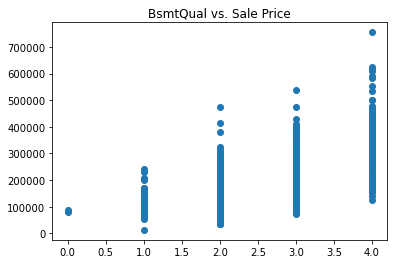

In [218]:
#Shows some correlation, might want to keep
x = 'BsmtQual'
plt.scatter(housing[x], housing.SalePrice)
plt.title(f'{x} vs. Sale Price')

Text(0.5, 1.0, 'BsmtQual vs. Sale Price')

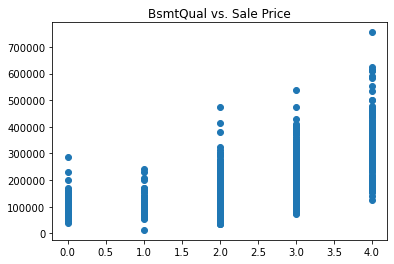

In [219]:
#But disrupted by imputation
x = 'BsmtQual'
plt.scatter(housing[x].fillna(0), housing.SalePrice)
plt.title(f'{x} vs. Sale Price')

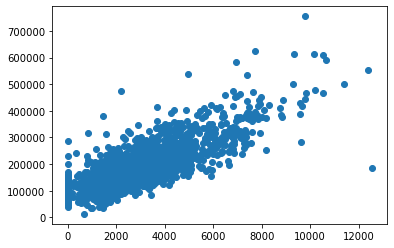

In [222]:
#Product appear better behaved except a few outliers
plt.scatter(housing['BsmtQual'].fillna(0) * housing.filter(regex='Bsmt.+SF').sum(axis = 1).fillna(0),  housing['SalePrice'])

In [223]:
#Replace with this new feature which captures related information
housing['TotBsmtSF*Qual'] = housing['BsmtQual'].fillna(0) * housing.filter(regex='Bsmt.+SF').sum(axis = 1)
housing.drop('BsmtQual', axis = 1, inplace = True)

### Garage year built

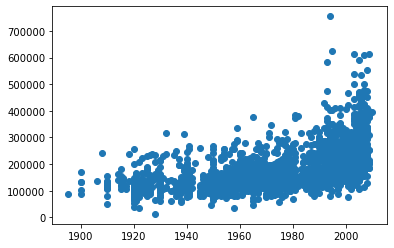

In [203]:
#Does appear that garages older than a certain period do not sell above a certain rate
plt.scatter(housing.GarageYrBlt, housing.SalePrice)

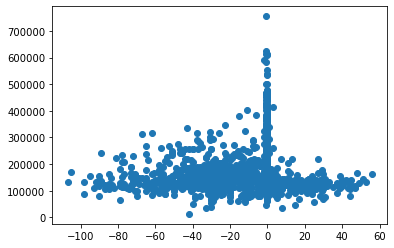

In [189]:
#However, effect shrinks significantly when comparing it versus the year of remodeling, which is a better indicator
plt.scatter(housing['GarageYrBlt'] - housing['YearRemodAdd'],  housing['SalePrice'])

In [224]:
#drop column
housing.drop('GarageYrBlt', axis = 1, inplace = True)

In [227]:
assert housing.isna().sum().sum()  == 0

## Check price distribution

<AxesSubplot:>

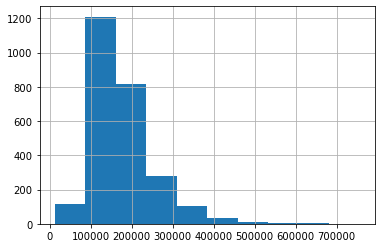

In [250]:
housing.SalePrice.hist()

<AxesSubplot:>

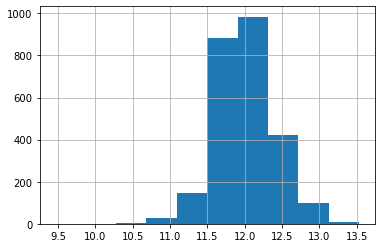

In [252]:
np.log(housing.SalePrice).hist()